# ***三大法人籌碼面台指期貨交易策略***

本策略基於追蹤市場中所謂「聰明錢」的流向，即三大法人（外資、投信、自營商）的動向。策略假設，當三大法人對市場未來方向有一致且強烈的看法時，跟隨其方向進行交易的勝率較高。

### 投資標的與回測期間
本研究以台灣指數期貨（台指期, TX）作為唯一的交易標的，並使用每日的最高價、最低價、收盤價資料（用於計算 ATR 波動率），以及三大法人的未平倉數據（用於產生交易訊號）。由於策略中的波動濾網需要一段時間的歷史數據進行（warm-up），其中最長的計算週期為 `vol_window` (252天)，為了確保回測開始時有足夠穩定的歷史數據，實際回測期間定為 **2016年1月1日** 至 **2025年10月1日**，以確保所有交易訊號的嚴謹性與有效性。

## 交易邏輯

1. 三大法人未平倉淨口數：
    - 這是策略的核心指標，代表市場主力的多空看法。
    - **淨多單（>0）**：表示三大法人整體對後市看漲。
    - **淨空單（<0）**：表示三大法人整體對後市看跌。
    - 策略只在淨口數的絕對值超過一個門檻時，才認為信號具有足夠的強度，值得進場。

2. **ATR(Average True Range)**：
    - 本策略使用 ATR 來衡量市場的波動程度，並作為一個風險過濾器。
    - 當近期的 ATR 超過過去一段時間（例如一年）的90％分位數時，我們認定市場進入了「異常高波動」狀態。
    - 在這種狀態下，市場方向難以預測，風險劇增， 因此策略會**清空所有倉位並停止交易**，以規避風險。

## 交易策略
### 進場條件

1. 無持有倉位
2. 市場未處於「異常高波動」狀態。
3. 三大法人未平倉淨口數的絕對值 > 5000（進場的門檻）。
4. 根據每天三大法人未平倉量調整倉位 

> 如果 `net_oi` 為正，則做多；如果為負，則做空。倉位大小由 `round(net_oi / 1000)` 決定。例如：今天未平倉量10000，則下單10口，明天未平倉量11000，在下一口。

### 出場條件

當滿足以下任一條件時，策略會平倉出場：
1. 市場進入「異常高波動」狀態（ATR 高於過去一年的90%分位數）
2. 三大法人未平倉淨口數的絕對值 < 1000（出場的低門檻）。

> 這種進出場門檻的不同設計被稱為 **Hysteresis（磁滯/緩衝區）**，目的是為了防止策略在信號臨界點附近因小波動而頻繁進出，增加交易的穩定性。



### 轉倉邏輯
期貨合約到期日的前一天，zipline 會自動將即將到期的合約平倉，策略邏輯會在下一個月份的主力合約上建立新倉位，以確保交易的連續性。（如需提前轉倉仍需寫 roll_futures）

In [ ]:
import os

os.environ['TEJAPI_KEY'] = 'YOUR_KEY'
os.environ['TEJAPI_BASE'] = 'http://tejapi.tejwin.com'

os.environ['ticker'] = 'IR0001'
os.environ['future'] = 'TX'
os.environ['mdate'] = '20100101 20250920'

!zipline ingest -b tquant_future

[2025-10-21 01:57:10.559769] INFO: zipline.data.bundles.core: Ingesting tquant_future.
Merging daily equity files:  [####################################]     
[2025-10-21 01:57:13.881788] INFO: zipline.data.bundles.core: Ingest tquant_future successfully.


In [2]:
import pandas as pd
import numpy as np
import talib
import pyfolio as pf
from zipline import run_algorithm
from zipline.api import(
    continuous_future,
    order_target,
    get_datetime,
    schedule_function,
    date_rules,
    time_rules,
    record,
    set_commission,
    set_slippage,
    symbol,
    set_benchmark,
    get_open_orders,
)
from zipline.finance import commission, slippage
from zipline.TQresearch.futures_smart_money_positions import institution_future_data
from zipline.assets import Future

In [3]:
def initialize(context):
    context.tx_future = continuous_future('TX', offset = 0, roll = 'calendar', adjustment = None)
    context.benchmark_asset = symbol('IR0001')
    set_commission(futures = commission.PerContract(cost = 200, exchange_fee = 0))
    set_slippage(futures = slippage.FixedSlippage(spread = 10))
    set_benchmark(symbol('IR0001'))
    
    # 門檻
    context.signal_threshold = 5000
    context.exit_threshold = 1000
    
    # 波動濾網參數
    context.atr_window = 12
    context.vol_window = 252
    context.vol_quantile = 0.9
    
    # 下載法人數據
    start_date = '2010-01-01'
    end_date = '2025-10-15'
    print('正在下載三大法人未平倉數據...')
    
    all_inst_data = institution_future_data.get_futures_institutions_data(root_symbol = ['TX'], st = start_date)
    if not all_inst_data.empty:
        df = all_inst_data.set_index('mdate')
        df['calculated_net_oi'] = df['oi_con_ls_net_dealers'] + df['oi_con_ls_net_finis'] + df['oi_con_ls_net_funds']
        context.major_inst_oi = df[['calculated_net_oi']]
    else:
        context.major_inst_oi = pd.DataFrame()
        print("警告：未下載到任何三大法人數據")
    
    schedule_function(rebalance, date_rule = date_rules.every_day(), time_rule = time_rules.market_open())

### 每日交易邏輯

In [4]:
def rebalance(context, data):
    current_dt = get_datetime().tz_localize(None)
    
    try:
        # 抓三大法人資料
        df = context.major_inst_oi
        if df is None or df.empty:
            return
        
        try:
            session_dt = pd.Timestamp(data.current_session).tz_localize(None).normalize()
        except Exception:
            session_dt = current_dt.normalize()
        
        idx_ts = pd.to_datetime(df.index)
        
        try:
            idx_ts = idx_ts.tz_convert(None)
        except Exception:
            idx_ts = idx_ts.tz_localize(None)
        
        idx_norm = idx_ts.normalize()
        # 取出小於現在時間的資料
        mask = idx_norm < session_dt
        
        if not mask.any():
            return
        
        last_idx = df.index[mask][-1]
        signal_row = df.loc[[last_idx]]
        net_oi = signal_row["calculated_net_oi"].iloc[0]
        if pd.isna(net_oi):
            return
        
        # ATR 波動濾網
        history = data.history(
            context.tx_future,
            ["high", "low", "close"],
            context.vol_window + context.atr_window + 2,
            "1d"
        )
        atr_series = talib.ATR(
            history['high'],
            history['low'],
            history['close'],
            timeperiod = context.atr_window
        )
        valid_atr = atr_series.dropna()
        
        is_vol_high = False
        current_atr = np.nan
        vol_threshold = np.nan
        
        if len(atr_series) >= context.vol_window + 1:
            current_atr = atr_series.iloc[-1]
            past_atrs = atr_series.iloc[-(context.vol_window + 1): -1]
            vol_threshold = past_atrs.quantile(context.vol_quantile)
            is_vol_high = current_atr > vol_threshold
        
        # 當前交易合約與現有口數
        current_contract = data.current(context.tx_future, "contract")
        if current_contract is None:
            return
        pos = context.portfolio.positions.get(current_contract)
        current_qty = int(pos.amount) if pos else 0
        
        raw_target = int(round(net_oi / 1000))
        final_target = current_qty
        
        # 實現交易邏輯
        if is_vol_high:
            final_target = 0
        else:
            if abs(net_oi) < context.exit_threshold:
                final_target = 0
            elif abs(net_oi) > context.signal_threshold:
                final_target = raw_target
        
        open_orders = get_open_orders()
        if current_contract not in open_orders:
            if final_target != current_qty:
                order_target(current_contract, final_target)
                print(
                    f"{current_dt.date()} 調整口數 {current_qty} 到 {final_target}"
                    f"net_oi = {net_oi}, ATR = {current_atr:.2f}, high_vol = {is_vol_high}"   
                )
        
        record(
            target_pos = final_target,
            net_oi = net_oi,
            atr = current_atr,
            vol_threshold = vol_threshold,
            is_vol_high = int(is_vol_high)
        )
    except Exception as e:
        print(f"Error in rebalance on {current_dt}: {e}")

### 使用 Pyfolio 進行回測

In [5]:
def analyze(context, results):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    benchmark_rets = results.benchmark_return
    
    print("------ 大盤績效指標 ------")
    pf.show_perf_stats(benchmark_rets)
    
    print("------ 策略績效指標 ------")
    pf.create_returns_tear_sheet(
        returns = returns,
        positions = positions,
        transactions = transactions,
        benchmark_rets = benchmark_rets
    )

正在下載三大法人未平倉數據...
2019-01-02 調整口數 0 到 11net_oi = 10682.0, ATR = 137.59, high_vol = False
2019-01-08 調整口數 11 到 13net_oi = 13367.0, ATR = 137.38, high_vol = False
2019-01-09 調整口數 13 到 11net_oi = 10782.0, ATR = 142.10, high_vol = False
2019-01-10 調整口數 11 到 21net_oi = 21098.0, ATR = 133.59, high_vol = False
2019-01-11 調整口數 21 到 23net_oi = 23015.0, ATR = 131.54, high_vol = False
2019-01-14 調整口數 23 到 24net_oi = 24303.0, ATR = 128.58, high_vol = False
2019-01-15 調整口數 24 到 21net_oi = 20985.0, ATR = 128.37, high_vol = False
2019-01-16 調整口數 21 到 28net_oi = 28267.0, ATR = 121.75, high_vol = False
2019-01-17 調整口數 0 到 22net_oi = 21888.0, ATR = 121.02, high_vol = False
2019-01-18 調整口數 22 到 25net_oi = 24601.0, ATR = 117.27, high_vol = False
2019-01-21 調整口數 25 到 26net_oi = 26277.0, ATR = 115.75, high_vol = False
2019-01-22 調整口數 26 到 27net_oi = 26816.0, ATR = 109.94, high_vol = False
2019-01-23 調整口數 27 到 28net_oi = 28134.0, ATR = 105.19, high_vol = False
2019-01-24 調整口數 28 到 22net_oi = 22196.0, ATR = 10

Start date,2019-01-02
End date,2025-10-01
Total months,78
,Backtest
Annual return,20.698%
Cumulative returns,240.174%
Annual volatility,18.705%
Sharpe ratio,1.10
Calmar ratio,0.72
Stability,0.89
Max drawdown,-28.553%


------ 策略績效指標 ------


Start date,2019-01-02
End date,2025-10-01
Total months,78
,Backtest
Annual return,26.594%
Cumulative returns,363.978%
Annual volatility,19.31%
Sharpe ratio,1.32
Calmar ratio,1.34
Stability,0.77
Max drawdown,-19.88%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.88,2021-08-17,2022-06-13,2024-09-04,743
1,17.10,2019-05-03,2019-05-29,2019-10-08,109
2,17.01,2024-11-29,2025-01-07,2025-03-27,76
3,9.22,2024-11-01,2024-11-08,2024-11-12,8
4,8.87,2024-09-04,2024-10-15,2024-11-01,38


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

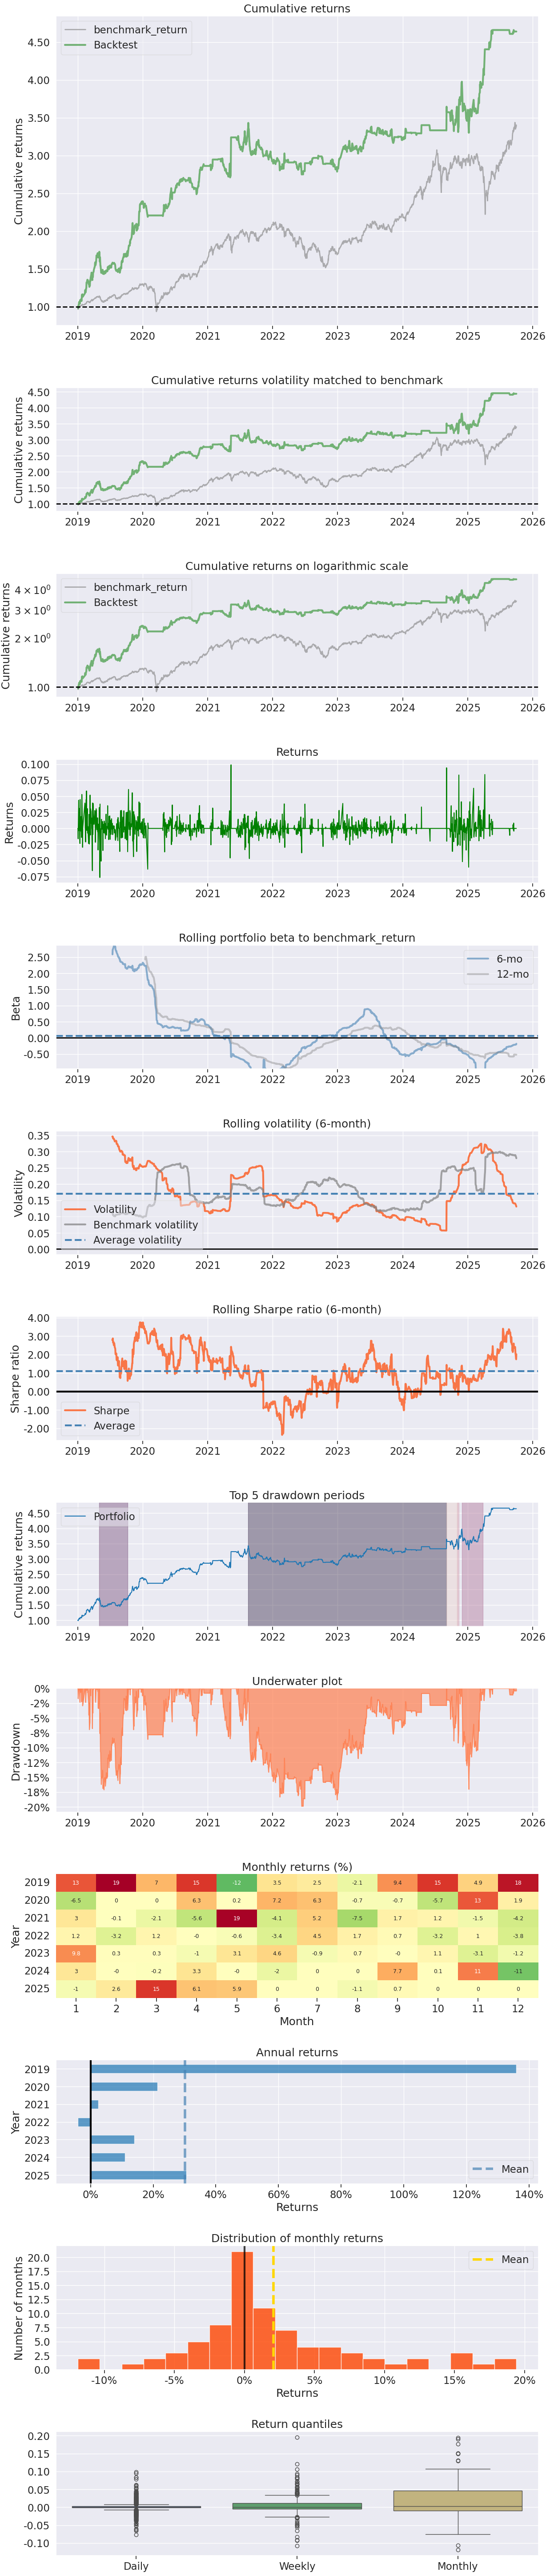

In [8]:
if __name__ == '__main__':
    start_date = pd.Timestamp('2019-01-01', tz = 'utc')
    end_date = pd.Timestamp('2025-10-1', tz = 'utc')
    
    result = run_algorithm(
        start = start_date,
        end = end_date,
        initialize = initialize,
        capital_base = 10000000,
        analyze = analyze,
        data_frequency = 'daily',
        bundle = 'tquant_future'
    )